Import Libraries

In [ ]:
# --- Import necessary libraries ---
import pandas as pd  # for data handling
import numpy as np  # for numerical operations
import matplotlib.pyplot as plt  # for plotting
import keras
import statsmodels
import sklearn
import tensorflow as tf
import matplotlib.dates as mdates
import pmdarima as pm  # for auto_arima to find best model order
from tabulate import tabulate  # Import tabulate for formatted tables
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # for ACF/PACF plots
from statsmodels.tsa.stattools import adfuller  # for stationarity test (ADF test)
from statsmodels.tsa.arima.model import ARIMA  # for ARIMA/ARMA modeling
from sklearn.metrics import mean_squared_error, mean_absolute_error  # evaluation metrics
from scipy.stats import boxcox  # Import Box-Cox transformation
from sklearn.preprocessing import MinMaxScaler  # for normalizing data in LSTM/GRU
from keras.models import Sequential  # for building RNN models
from keras.layers import Dense, LSTM, GRU  # for RNN layers
from keras.callbacks import EarlyStopping

import warnings  # to suppress warnings

# Suppress warnings and set plot size
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [8, 4]


Load and Prepare Datasets

In [ ]:


# --- Load Johnson & Johnson Sales Data ---
jj_data = pd.read_csv('/content/drive/MyDrive/Research project/jj.csv', parse_dates=['date'])

# Rename column to 'value' for consistency
jj_data = jj_data.rename(columns={'data': 'value'})

# Set 'date' as index and set quarterly frequency
jj_data.set_index('date', inplace=True)
jj_data = jj_data.asfreq('QS')  # QS: Quarter Start

# Fill missing values with linear interpolation
jj_data.interpolate(inplace=True)

# --- Load Amazon Stock Price Data ---
amzn_data = pd.read_csv('/content/drive/MyDrive/Research project/AMZN.csv', parse_dates=['Date'])

# Set 'Date' as index and use only the 'Close' column
amzn_data.set_index('Date', inplace=True)
amzn_data = amzn_data[['Close']]
amzn_data = amzn_data.asfreq('B')  # B: Business day frequency
amzn_data.interpolate(inplace=True)

# Print the first few rows of both datasets
print("Johnson & Johnson Sales Data:")
print(jj_data.head())

print("\nAmazon Stock Price Data:")
print(amzn_data.head())


Johnson & Johnson Sales Data:
            value
date             
1960-01-01  0.710
1960-04-01  0.630
1960-07-01  0.535
1960-10-01  0.440
1961-01-01  0.610

Amazon Stock Price Data:
                Close
Date                 
2018-02-20  73.417503
2018-02-21  74.146004
2018-02-22  74.266998
2018-02-23  75.000000
2018-02-26  76.097504


Plot Original Data

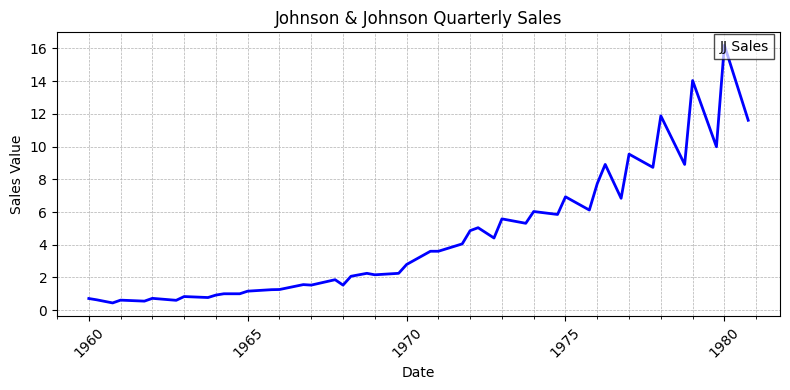

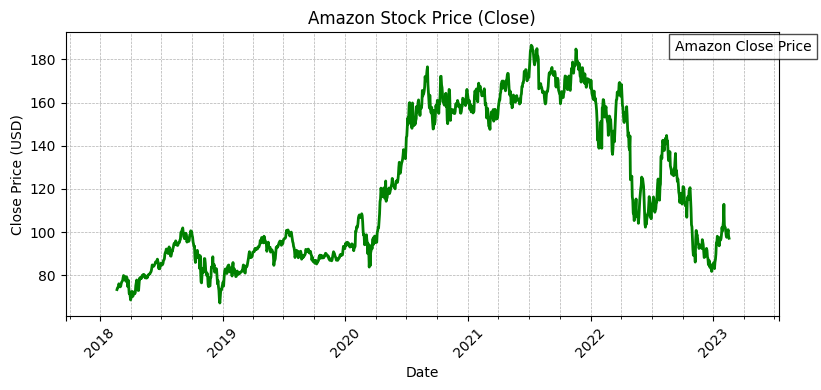

In [ ]:


# --- Plot JJ Sales ---
ax = jj_data['value'].plot(title='Johnson & Johnson Quarterly Sales', color='blue', linewidth=2)
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Sales Value')  # Label for the y-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Subtle gridlines
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Adding labels inside the plot at the top-right corner
plt.text(0.95, 0.95, 'JJ Sales', horizontalalignment='center', verticalalignment='center',
         transform=ax.transAxes, fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.7))

# Adjusting the x-axis to leave space
plt.xlim([jj_data.index.min() - pd.DateOffset(years=1), jj_data.index.max() + pd.DateOffset(years=1)])

plt.show()

# --- Plot Amazon Close Price ---
ax = amzn_data['Close'].plot(title='Amazon Stock Price (Close)', color='green', linewidth=2)
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Close Price (USD)')  # Label for the y-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Subtle gridlines
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Adding labels inside the plot at the top-right corner
plt.text(0.95, 0.95, 'Amazon Close Price', horizontalalignment='center', verticalalignment='center',
         transform=ax.transAxes, fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.7))

# Adjusting the x-axis to leave space
plt.xlim([amzn_data.index.min() - pd.DateOffset(months=5), amzn_data.index.max() + pd.DateOffset(months=5)])

plt.show()


Define the ADF Test Function and Box-Cox Transformation to JJ & Amazon Dataset

In [ ]:

# --- Define function for ADF test ---
def adf_test(series, label):
    result = adfuller(series.dropna())  # Drop NaN values before performing ADF test
    adf_statistic = result[0]
    p_value = result[1]
    stationarity = "Stationary" if p_value <= 0.05 else "Non-stationary"

    # Store the results in a DataFrame
    result_df = pd.DataFrame({
        'Dataset': [label],
        'ADF Statistic': [f"{adf_statistic:.4f}"],
        'p-value': [f"{p_value:.4f}"],
        'Stationarity': [stationarity]
    })

    return result_df

# --- Apply Box-Cox transformation to Johnson & Johnson dataset ---
jj_data['boxcox_value'], _ = boxcox(jj_data['value'] + 1)  # Add 1 to avoid issues with zero or negative values
jj_data['boxcox_diff'] = jj_data['boxcox_value'].diff()  # Apply differencing to Box-Cox transformed data

# --- Apply ADF test for Johnson & Johnson dataset ---
jj_boxcox_result = adf_test(jj_data['boxcox_value'], "Johnson & Johnson Box-Cox Transformed")
jj_boxcox_diff_result = adf_test(jj_data['boxcox_diff'].dropna(), "Johnson & Johnson Box-Cox Differenced")

# --- Apply Box-Cox transformation to Amazon dataset ---
amzn_data['boxcox_close'], _ = boxcox(amzn_data['Close'] + 1)  # Add 1 to avoid issues with zero or negative values
amzn_data['boxcox_diff'] = amzn_data['boxcox_close'].diff()  # Apply differencing to Box-Cox transformed data

# --- Apply ADF test for Amazon dataset ---
amzn_boxcox_result = adf_test(amzn_data['boxcox_close'], "Amazon Box-Cox Transformed")
amzn_boxcox_diff_result = adf_test(amzn_data['boxcox_diff'].dropna(), "Amazon Box-Cox Differenced")

# --- Combine the results ---
results = pd.concat([jj_boxcox_result, jj_boxcox_diff_result, amzn_boxcox_result, amzn_boxcox_diff_result])

# --- Print the results ---
print(results)


                                 Dataset ADF Statistic p-value    Stationarity
0  Johnson & Johnson Box-Cox Transformed       -0.3689  0.9152  Non-stationary
0  Johnson & Johnson Box-Cox Differenced       -2.9955  0.0353      Stationary
0             Amazon Box-Cox Transformed       -1.8461  0.3578  Non-stationary
0             Amazon Box-Cox Differenced      -36.7938  0.0000      Stationary


Plot Log Differenced Series for JJ and Amazon

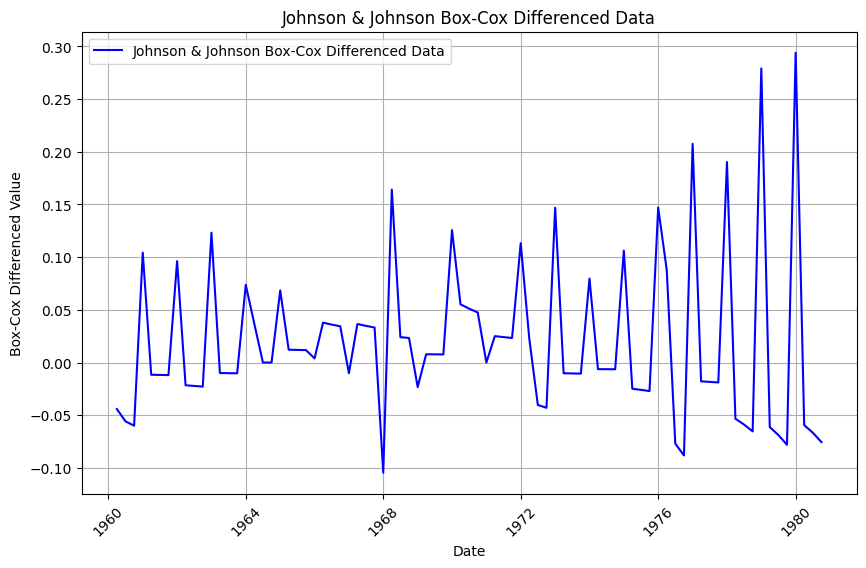

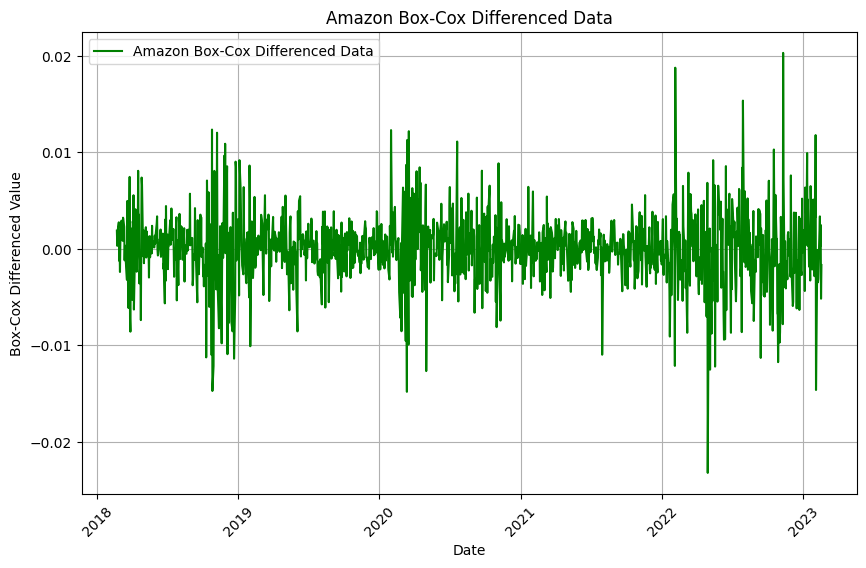

In [ ]:

# Plot the differenced Box-Cox data for Johnson & Johnson
plt.figure(figsize=(10, 6))
plt.plot(jj_data.index, jj_data['boxcox_diff'], label='Johnson & Johnson Box-Cox Differenced Data', color='blue')
plt.title('Johnson & Johnson Box-Cox Differenced Data')
plt.xlabel('Date')
plt.ylabel('Box-Cox Differenced Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  # Adding grid
plt.show()


# Plot the differenced Box-Cox data for Amazon
plt.figure(figsize=(10, 6))
plt.plot(amzn_data.index, amzn_data['boxcox_diff'], label='Amazon Box-Cox Differenced Data', color='green')
plt.title('Amazon Box-Cox Differenced Data')
plt.xlabel('Date')
plt.ylabel('Box-Cox Differenced Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  # Adding grid
plt.show()


Plot ACF and PACF for JJ and Amazon

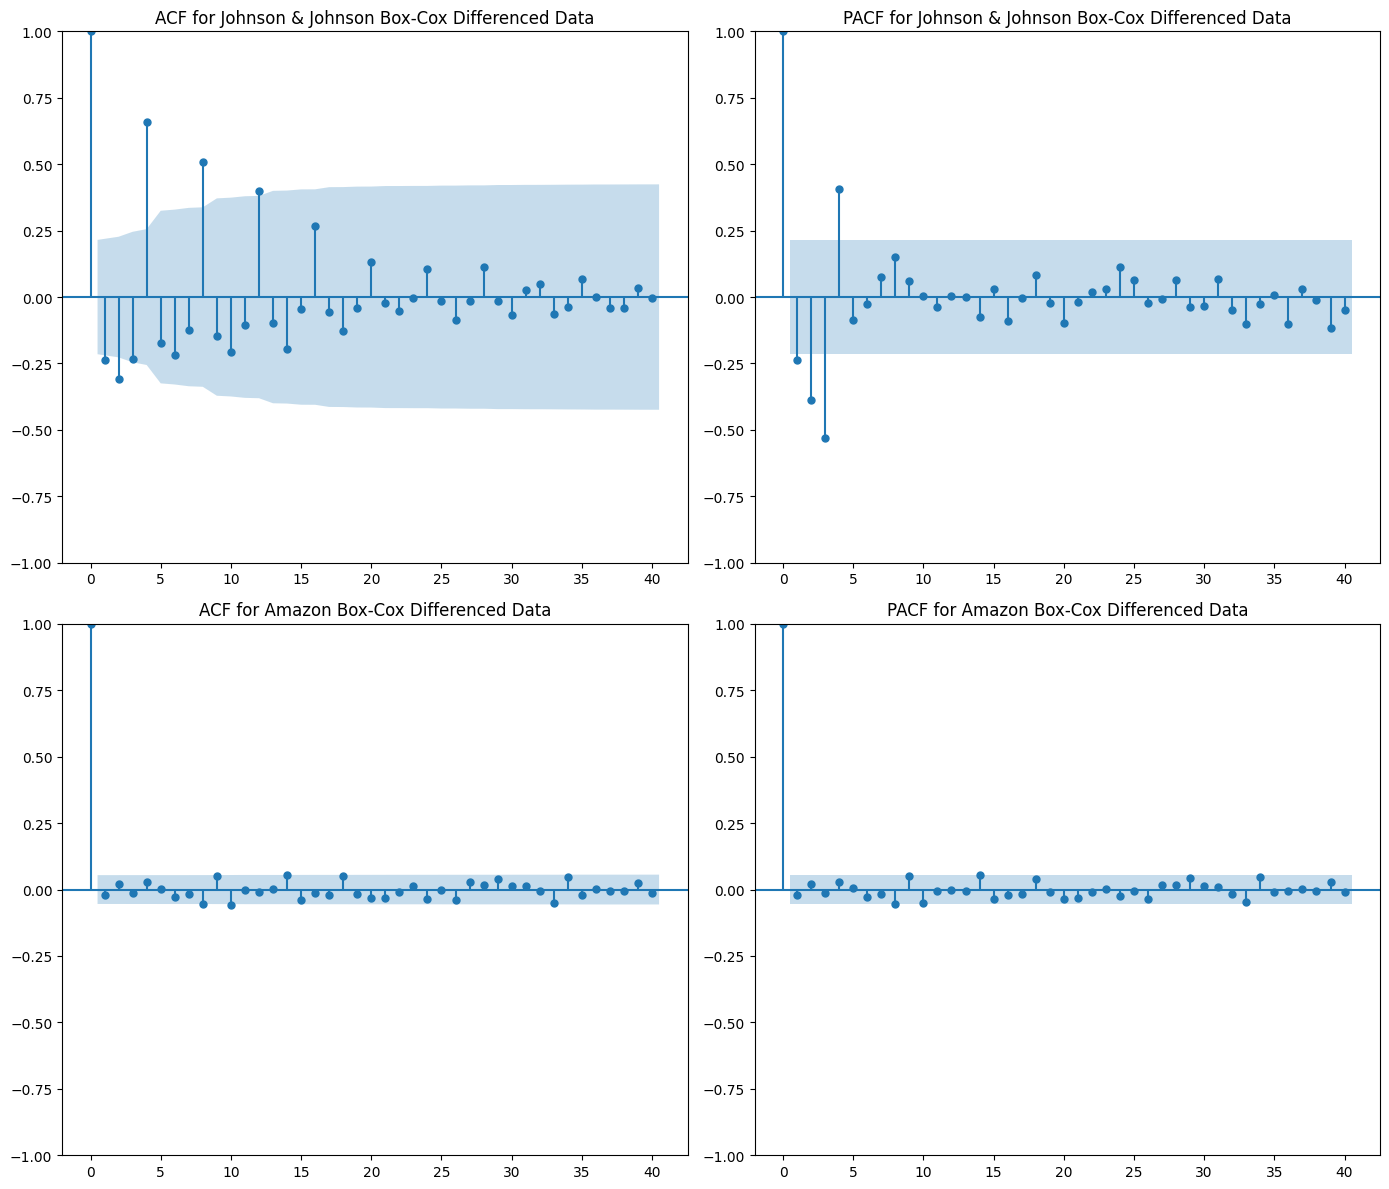

In [ ]:

# Create a figure with subplots for both datasets
plt.figure(figsize=(14, 12))

# Plot ACF and PACF for Johnson & Johnson Box-Cox Differenced Data
# ACF Plot for JJ
plt.subplot(2, 2, 1)
plot_acf(jj_data['boxcox_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF for Johnson & Johnson Box-Cox Differenced Data')

# PACF Plot for JJ
plt.subplot(2, 2, 2)
plot_pacf(jj_data['boxcox_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF for Johnson & Johnson Box-Cox Differenced Data')

# Plot ACF and PACF for Amazon Box-Cox Differenced Data
# ACF Plot for Amazon
plt.subplot(2, 2, 3)
plot_acf(amzn_data['boxcox_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF for Amazon Box-Cox Differenced Data')

# PACF Plot for Amazon
plt.subplot(2, 2, 4)
plot_pacf(amzn_data['boxcox_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF for Amazon Box-Cox Differenced Data')

plt.tight_layout()
plt.show()


Manual ARMA(p, d, q) Search Function

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Function to find best ARMA model based on AIC
def find_best_arma_model(series):
    best_aic = np.inf
    best_order = None

    # Loop through possible combinations of p and q values (up to a maximum value of 5)
    for p in range(6):  # AR order
        for q in range(6):  # MA order
            try:
                model = ARIMA(series, order=(p, 0, q))
                model_fit = model.fit()
                aic = model_fit.aic

                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, q)
            except:
                continue

    return best_order, best_aic

# Find best ARMA model for Johnson & Johnson
best_order_jj, best_aic_jj = find_best_arma_model(jj_data['boxcox_diff'].dropna())
print(f"Best ARMA Model for JJ: Order: {best_order_jj}, AIC: {best_aic_jj}")

# Find best ARMA model for Amazon
best_order_amzn, best_aic_amzn = find_best_arma_model(amzn_data['boxcox_diff'].dropna())
print(f"Best ARMA Model for Amazon: Order: {best_order_amzn}, AIC: {best_aic_amzn}")


Best ARMA Model for JJ: Order: (4, 0), AIC: -263.6113699152657
Best ARMA Model for Amazon: Order: (0, 0), AIC: -10936.958958816289


Automated ARIMA with pmdarima

In [ ]:
import pmdarima as pm

# Automated ARIMA using pmdarima (Auto ARIMA)
auto_model_jj = pm.auto_arima(jj_data['boxcox_diff'].dropna(), seasonal=False, stepwise=True)
arma_order_jj = (auto_model_jj.order[0], 0, auto_model_jj.order[2])  # Extracting the p and q values

auto_model_amzn = pm.auto_arima(amzn_data['boxcox_diff'].dropna(), seasonal=False, stepwise=True)
arma_order_amzn = (auto_model_amzn.order[0], 0, auto_model_amzn.order[2])  # Extracting the p and q values

print(f"Best ARMA Model for JJ (AutoARIMA): Order: {arma_order_jj}")
print(f"Best ARMA Model for Amazon (AutoARIMA): Order: {arma_order_amzn}")


Best ARMA Model for JJ (AutoARIMA): Order: (4, 0, 0)
Best ARMA Model for Amazon (AutoARIMA): Order: (0, 0, 0)


Fit ARIMA model on differenced data for Johnson & Johnson and Amazon

In [ ]:

# Johnson & Johnson Manual ARIMA Fit (after differencing Box-Cox data)
# Based on ACF and PACF analysis, you can manually specify p, d, q.
jj_model_manual = ARIMA(jj_data['boxcox_diff'].dropna(), order=(4, 0, 0))  # Example: p=3, d=1, q=3
jj_model_manual_fit = jj_model_manual.fit()

# Amazon Manual ARIMA Fit (after differencing Box-Cox data)
# Based on ACF and PACF analysis, you can manually specify p, d, q.
amzn_model_manual = ARIMA(amzn_data['boxcox_diff'].dropna(), order=(0, 0, 0))  # Example: p=3, d=1, q=2
amzn_model_manual_fit = amzn_model_manual.fit()

# Print the results for manual ARIMA fit
print("\n--- Johnson & Johnson (Manual ARIMA) ---")
print(jj_model_manual_fit.summary())

print("\n--- Amazon (Manual ARIMA) ---")
print(amzn_model_manual_fit.summary())



--- Johnson & Johnson (Manual ARIMA) ---
                               SARIMAX Results                                
Dep. Variable:            boxcox_diff   No. Observations:                   83
Model:                 ARIMA(4, 0, 0)   Log Likelihood                 137.806
Date:                Fri, 11 Apr 2025   AIC                           -263.611
Time:                        10:42:46   BIC                           -249.098
Sample:                    04-01-1960   HQIC                          -257.781
                         - 10-01-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0212      0.003      6.631      0.000       0.015       0.027
ar.L1         -0.4205      0.084     -5.027      0.000      -0.584      -0.257
ar.L2     

Produce the forecast for the next 24 months

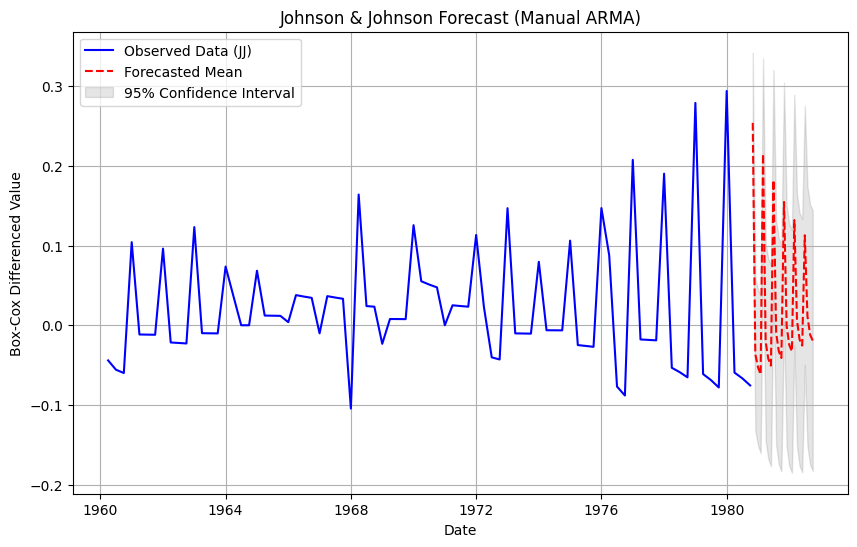

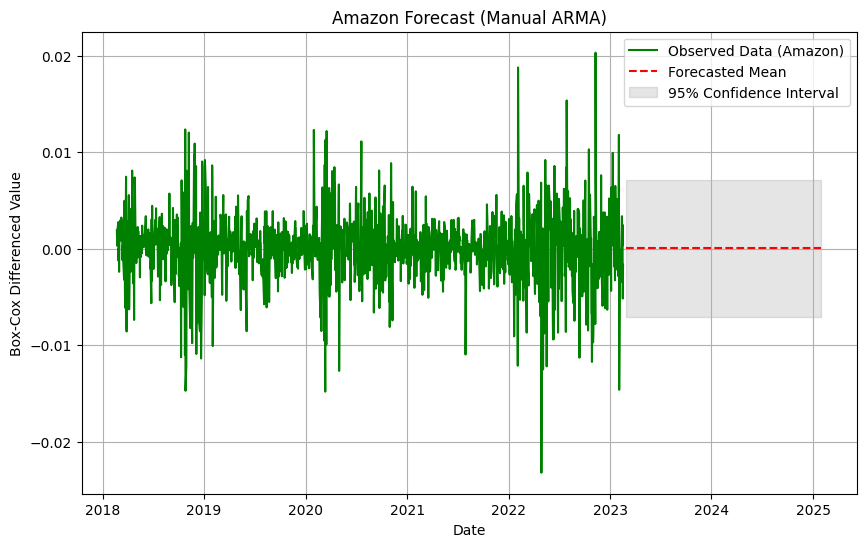

In [ ]:
# --- Johnson & Johnson ARMA Model (Manual) ---
jj_model_manual = ARIMA(jj_data['boxcox_diff'].dropna(), order=(4, 0, 0))  # Use best order (4, 0) for JJ
jj_model_manual_fit = jj_model_manual.fit()

# --- Amazon ARMA Model (Manual) ---
amzn_model_manual = ARIMA(amzn_data['boxcox_diff'].dropna(), order=(0, 0, 0))  # Use best order (0, 0) for Amazon
amzn_model_manual_fit = amzn_model_manual.fit()

# --- Forecasting for 24 months ---
n_forecast = 24  # Number of months to forecast

# Johnson & Johnson Forecast
jj_forecast = jj_model_manual_fit.get_forecast(steps=n_forecast)
jj_predicted_mean = jj_forecast.predicted_mean
jj_conf_int = jj_forecast.conf_int()

# Amazon Forecast
amzn_forecast = amzn_model_manual_fit.get_forecast(steps=n_forecast)
amzn_predicted_mean = amzn_forecast.predicted_mean
amzn_conf_int = amzn_forecast.conf_int()

# Plotting Forecast for Johnson & Johnson
forecast_index_jj = pd.date_range(start=jj_data.index[-1] + pd.Timedelta(days=1), periods=n_forecast, freq='M')
plt.figure(figsize=(10, 6))
plt.plot(jj_data.index, jj_data['boxcox_diff'], label='Observed Data (JJ)', color='blue')
plt.plot(forecast_index_jj, jj_predicted_mean, 'k--', label='Forecasted Mean', color='red')
plt.fill_between(forecast_index_jj, jj_conf_int.iloc[:, 0], jj_conf_int.iloc[:, 1], color='k', alpha=0.1, label='95% Confidence Interval')
plt.title('Johnson & Johnson Forecast (Manual ARMA)')
plt.xlabel('Date')
plt.ylabel('Box-Cox Differenced Value')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Forecast for Amazon
forecast_index_amzn = pd.date_range(start=amzn_data.index[-1] + pd.Timedelta(days=1), periods=n_forecast, freq='M')
plt.figure(figsize=(10, 6))
plt.plot(amzn_data.index, amzn_data['boxcox_diff'], label='Observed Data (Amazon)', color='green')
plt.plot(forecast_index_amzn, amzn_predicted_mean, 'k--', label='Forecasted Mean', color='red')
plt.fill_between(forecast_index_amzn, amzn_conf_int.iloc[:, 0], amzn_conf_int.iloc[:, 1], color='k', alpha=0.1, label='95% Confidence Interval')
plt.title('Amazon Forecast (Manual ARMA)')
plt.xlabel('Date')
plt.ylabel('Box-Cox Differenced Value')
plt.legend()
plt.grid(True)
plt.show()


Define Functions for LSTM and GRU


Running modeling pipeline for: Johnson & Johnson
1/1 [==============================] - 0s 458ms/step
LSTM Test: (0.10834612795470737, 0.1291430105709228, 144.36509907309613)
GRU Test: (0.10053059469917001, 0.11742239167728846, 138.24070970786963)


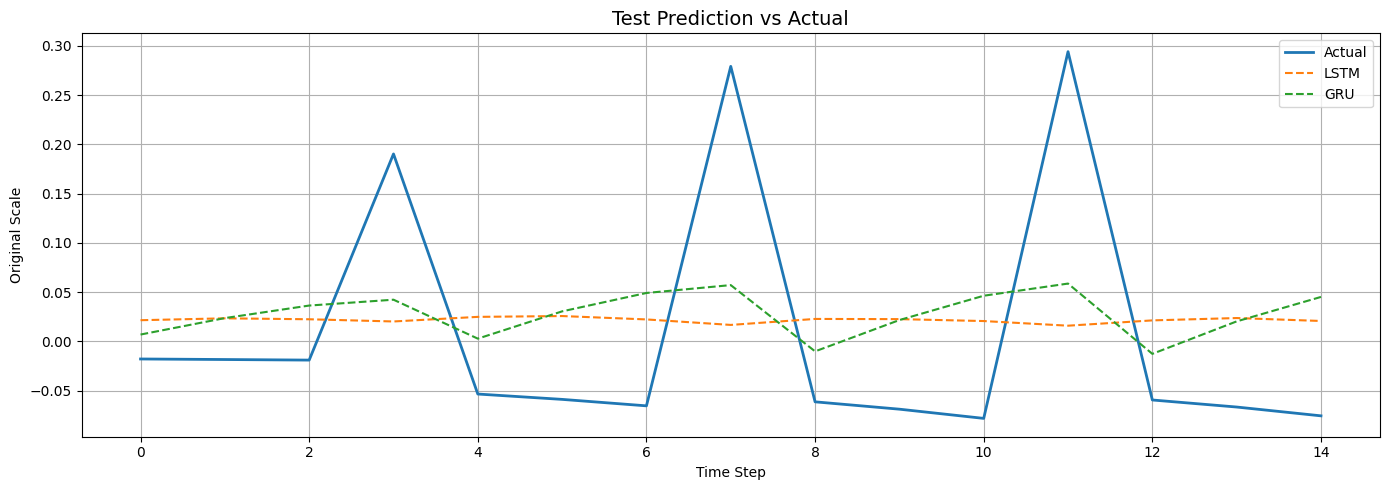

Forecast Evaluation (24 months)
LSTM Forecast: (0.09672694421159093, 0.11765950533592556, 118.25959645259687)
GRU Forecast: (0.10252329851441695, 0.11764920860737144, 145.76704374230945)


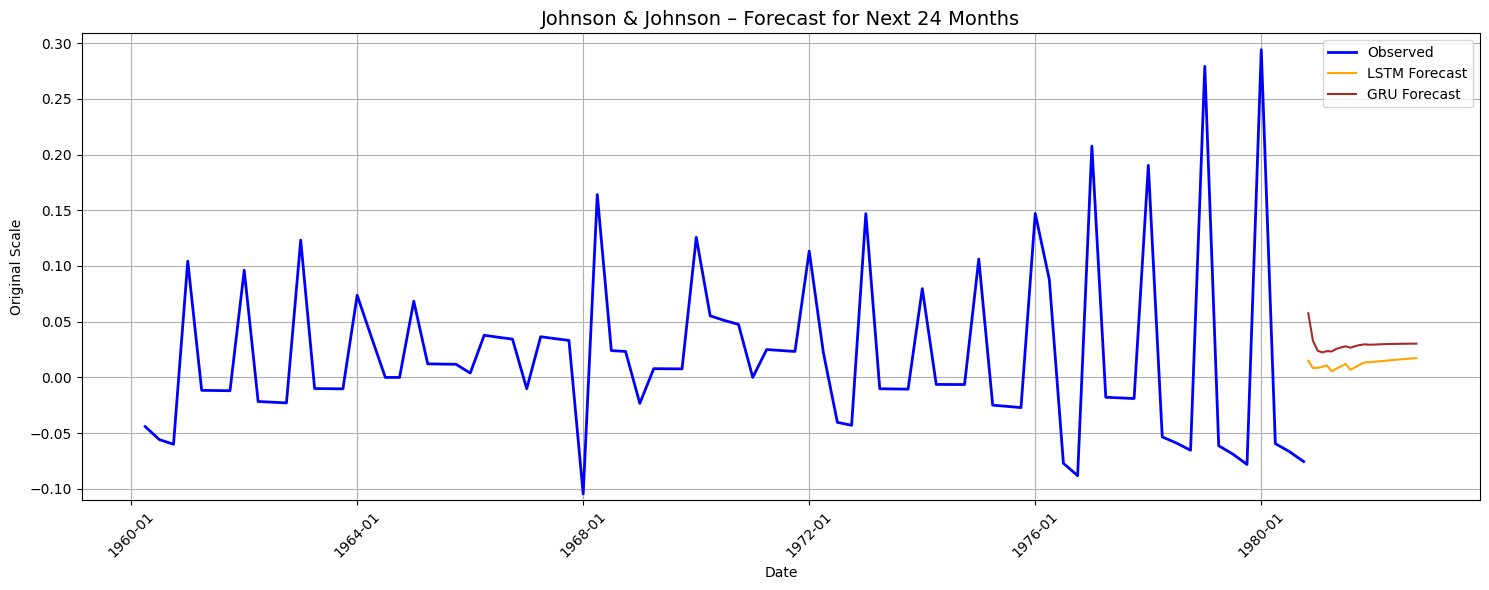


Evaluation Results:

  Model       MAE      RMSE    MAPE (%)
0  LSTM  0.108346  0.129143  144.365099
1   GRU  0.100531  0.117422  138.240710

Running modeling pipeline for: Amazon
9/9 [==============================] - 1s 4ms/step
LSTM Test: (0.00381743169052258, 0.005050455855216425, 144.16725481379206)
GRU Test: (0.003766644793694467, 0.004983340778847883, 133.41705598099483)


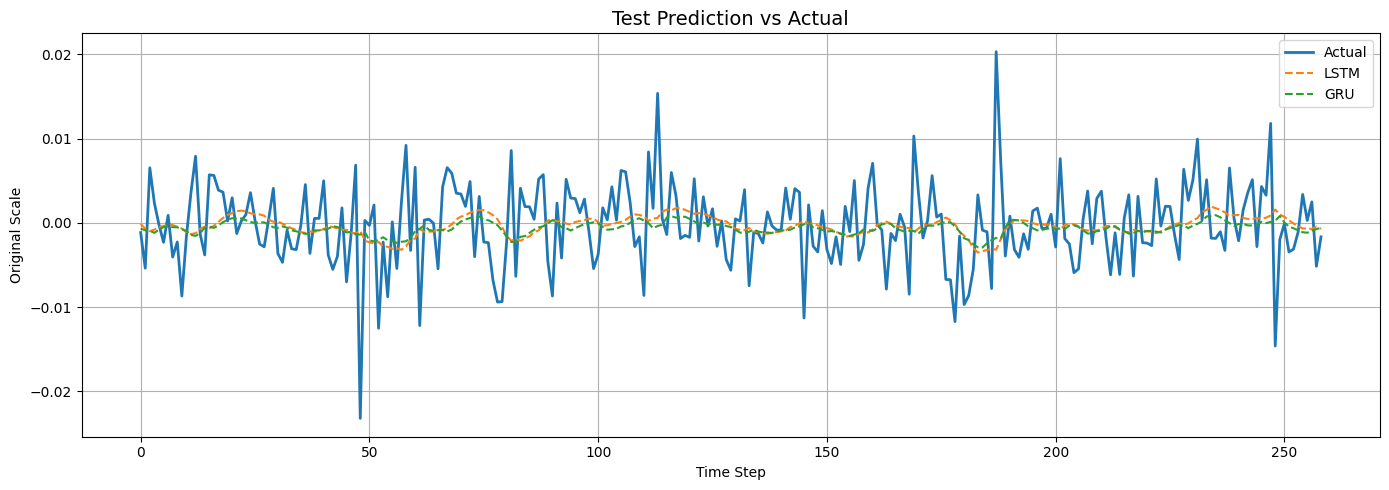

Forecast Evaluation (24 months)
LSTM Forecast: (0.003533582797861682, 0.004934801896217697, 125.20289515772302)
GRU Forecast: (0.003544008848647029, 0.004952270304075627, 134.22501144989482)


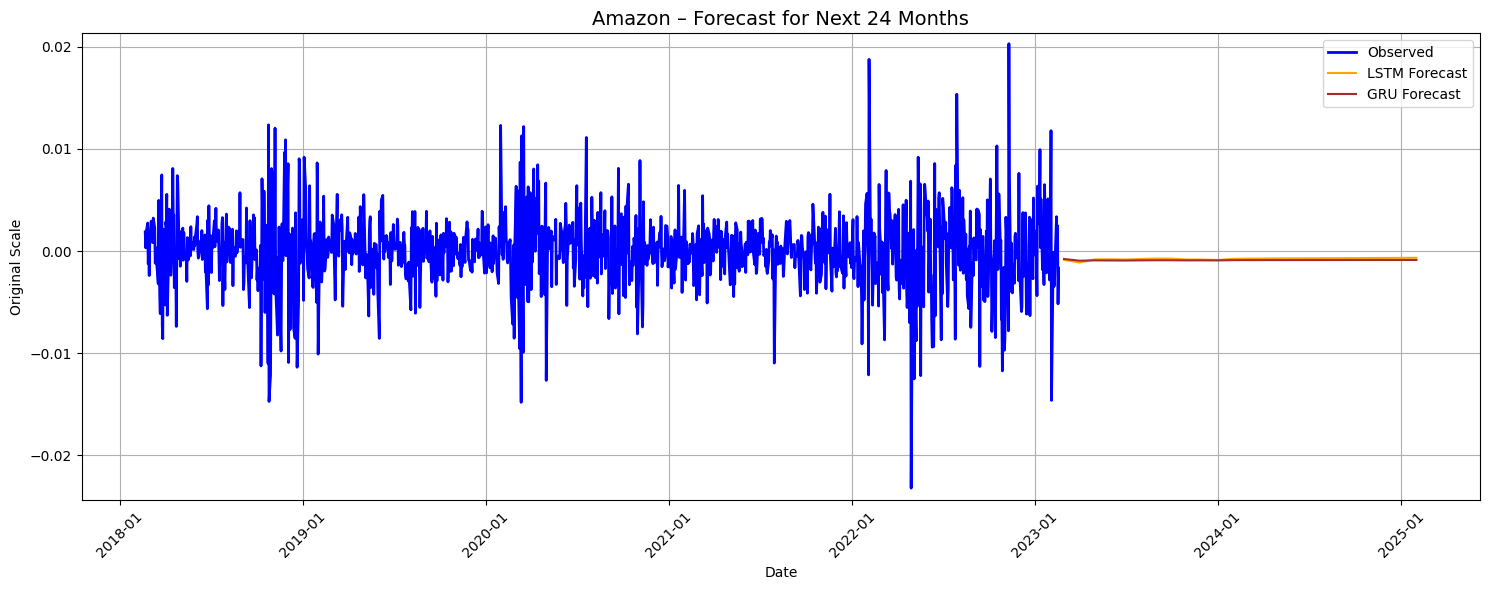


Evaluation Results:

  Model       MAE      RMSE    MAPE (%)
0  LSTM  0.003817  0.005050  144.167255
1   GRU  0.003767  0.004983  133.417056


In [ ]:
# --- Hyperparameters ---
lookback = 12
forecast_horizon = 24

# --- Helper: Create sequences ---
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

# --- Preprocessing ---
def preprocess_series(series, label):
    scaler = MinMaxScaler()
    scaled_series = scaler.fit_transform(series.dropna().values.reshape(-1, 1))

    X, y = create_sequences(scaled_series, lookback)

    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    return X_train, y_train, X_test, y_test, scaler, scaled_series

# --- Models ---
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(64, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# --- Recursive Forecast ---
def recursive_forecast(model, last_sequence, steps, scaler):
    forecast = []
    input_seq = last_sequence.copy()
    for _ in range(steps):
        pred = model.predict(input_seq[np.newaxis, :, :], verbose=0)[0, 0]
        forecast.append(pred)
        input_seq = np.append(input_seq[1:], [[pred]], axis=0)
    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

# --- Evaluation ---
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# --- Test Predictions vs Actual Plot ---
def plot_test_predictions_vs_actual(y_test_orig, lstm_pred, gru_pred):
    plt.figure(figsize=(14, 5))
    plt.plot(y_test_orig, label='Actual', linewidth=2)
    plt.plot(lstm_pred, label='LSTM', linestyle='--')
    plt.plot(gru_pred, label='GRU', linestyle='--')
    plt.title(f'Test Prediction vs Actual', fontsize=14)
    plt.xlabel('Time Step')
    plt.ylabel('Original Scale')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Modeling Pipeline ---
def run_modeling_pipeline(name, series):
    print(f"\nRunning modeling pipeline for: {name}")

    X_train, y_train, X_test, y_test, scaler, scaled_series = preprocess_series(series, name)
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    # Train LSTM
    lstm_model = build_lstm_model((lookback, 1))
    lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, callbacks=[early_stop], verbose=0)

    # Train GRU
    gru_model = build_gru_model((lookback, 1))
    gru_model.fit(X_train, y_train, epochs=50, batch_size=16, callbacks=[early_stop], verbose=0)

    # Test prediction
    lstm_pred = scaler.inverse_transform(lstm_model.predict(X_test)).flatten()
    gru_pred = scaler.inverse_transform(gru_model.predict(X_test)).flatten()
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    print("LSTM Test:", evaluate(y_test_orig, lstm_pred))
    print("GRU Test:", evaluate(y_test_orig, gru_pred))

    # --- Test Prediction vs Actual Plot ---
    plot_test_predictions_vs_actual(y_test_orig, lstm_pred, gru_pred)

    # --- Forecast ---
    last_input = scaled_series[-lookback:]
    lstm_forecast = recursive_forecast(lstm_model, last_input, forecast_horizon, scaler)
    gru_forecast = recursive_forecast(gru_model, last_input, forecast_horizon, scaler)

    print("Forecast Evaluation (24 months)")
    true_future = series.dropna().values[-forecast_horizon:] if len(series) >= forecast_horizon else None
    if true_future is not None and len(true_future) == forecast_horizon:
        print("LSTM Forecast:", evaluate(true_future, lstm_forecast))
        print("GRU Forecast:", evaluate(true_future, gru_forecast))

    # --- Plot Forecast ---
    future_index = pd.date_range(start=series.dropna().index[-1] + pd.offsets.MonthEnd(), periods=forecast_horizon, freq='M')

    plt.figure(figsize=(15, 6))
    plt.plot(series.index, series.values, label='Observed', linewidth=2, color='blue')
    plt.plot(future_index, lstm_forecast, label='LSTM Forecast', color='orange')
    plt.plot(future_index, gru_forecast, label='GRU Forecast', color='brown')
    plt.title(f'{name} – Forecast for Next {forecast_horizon} Months', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Original Scale')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    # Set y-axis limit to match historical + forecast scale
    full_range = np.concatenate([series.dropna().values.flatten(), lstm_forecast, gru_forecast])
    plt.ylim([full_range.min() - 0.05 * abs(full_range.min()), full_range.max() + 0.05 * abs(full_range.max())])

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Store Evaluation Results ---
    results = {
        'Model': ['LSTM', 'GRU'],
        'MAE': [evaluate(y_test_orig, lstm_pred)[0], evaluate(y_test_orig, gru_pred)[0]],
        'RMSE': [evaluate(y_test_orig, lstm_pred)[1], evaluate(y_test_orig, gru_pred)[1]],
        'MAPE (%)': [evaluate(y_test_orig, lstm_pred)[2], evaluate(y_test_orig, gru_pred)[2]],
    }

    results_df = pd.DataFrame(results)
    print("\nEvaluation Results:\n")
    print(results_df)

# --- Run ---
run_modeling_pipeline("Johnson & Johnson", jj_data['boxcox_diff'])
run_modeling_pipeline("Amazon", amzn_data['boxcox_diff'])

Compute and Plot the Periodogram

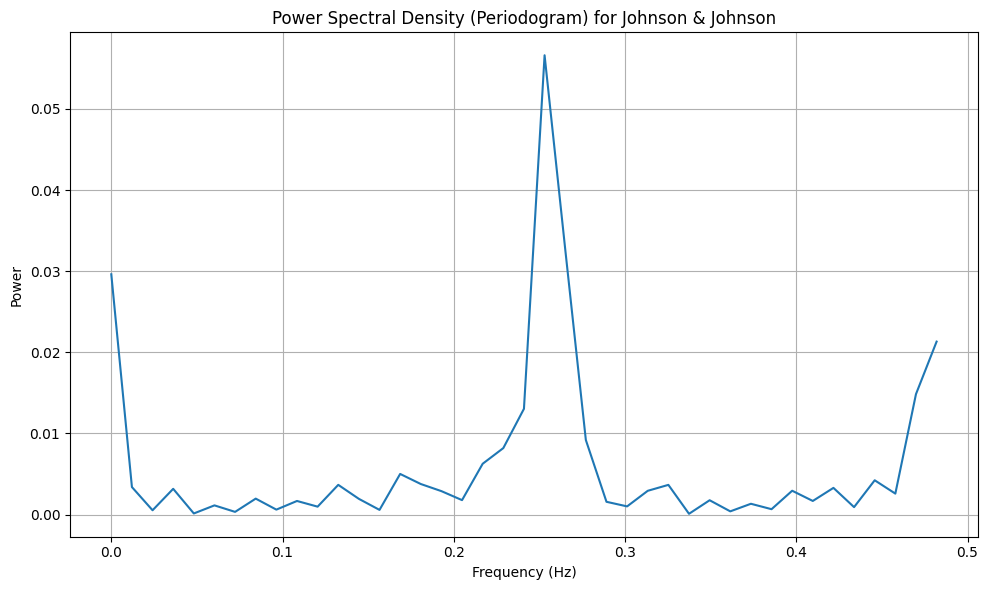

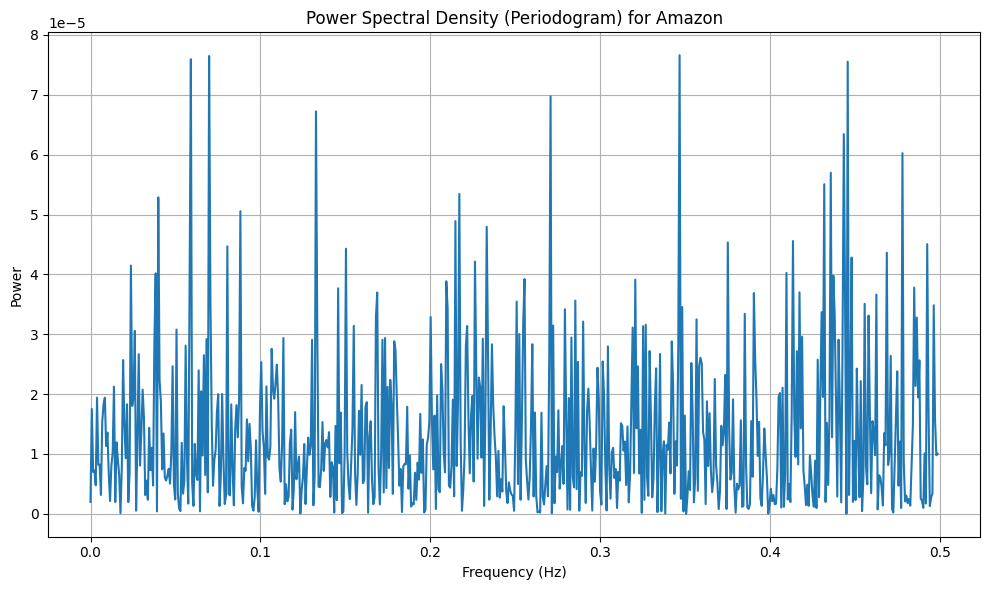

In [ ]:
# @title
# Function to compute and plot the periodogram
def plot_periodogram(series, label):
    # Perform FFT
    N = len(series)
    T = 1  # Assuming unit time step for simplicity
    fft_values = fft(series)
    frequencies = np.fft.fftfreq(N, T)

    # Compute the magnitude of FFT
    fft_magnitude = np.abs(fft_values)[:N // 2]
    frequencies = frequencies[:N // 2]

    # Compute Power Spectral Density (Periodogram)
    psd = np.square(fft_magnitude) / N

    # Plot the Periodogram
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, psd)
    plt.title(f'Power Spectral Density (Periodogram) for {label}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Plot Periodogram for Johnson & Johnson and Amazon ---
# Assuming the boxcox_diff data is already available for both datasets
plot_periodogram(jj_data['boxcox_diff'].dropna().values, 'Johnson & Johnson')
plot_periodogram(amzn_data['boxcox_diff'].dropna().values, 'Amazon')
